In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import random
import seaborn as sns
import numpy as np
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
conn = psycopg2.connect(
host = "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
  user = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c",
  password = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password",
  database = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db",
  port = '5432'
)

In [3]:
query1 = """select o.id as order_id,
            o.created_at::date as order_date,
            o.customer_id as user_id,
            oli.product_id as product_id,
            oli.name as product_name,
            o.total_price as order_amount,
            CASE
        WHEN cancelled_at IS NOT NULL THEN 'Cancelled'
         ELSE 'Delivered'
     END as order_status,
            oli.quantity as quantity,
            oli.price as sp
            from orders o
            join order_line_item oli on oli.order_id = o.id"""

In [4]:
data = pd.read_sql(query1, conn)

In [5]:
data["order_date"] = pd.to_datetime(data["order_date"])
data[data["product_id"] == np.nan]
data = data.dropna()
data['WeekCount']=data['order_date'].dt.strftime('%Y-w%W')
data=data.sort_values('order_date')
WeekList=data['WeekCount'].unique()
data = data[data['order_status'] != 'cancelled']

In [6]:
WeekList = WeekList.tolist()
output_list = []

for i in range(len(WeekList) - 1):
    output_list.append(WeekList[i])
    current_week = int(WeekList[i].split('-w')[1])
    next_week = int(WeekList[i + 1].split('-w')[1])
    missing_weeks = next_week - current_week - 1
    for j in range(1, missing_weeks + 1):
        missing_week = current_week + j
        output_list.append(f'{WeekList[i][:5]}w{missing_week:02d}')

output_list.append(WeekList[-1])

In [7]:
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel


data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()
data['DeltaDaysinOrders']=(data.groupby('user_id').order_date.shift() - data.order_date).dt.days.abs()
data['DeltaOrderValues']=(data.groupby('user_id').ordervalue.shift() - data.ordervalue)

In [8]:
Weekly_Stats = {}
productsegstats_weekly = {}
user_cohort_labels = ['New Users', 'Churned Users', 'Recent & Loyal Users', 'Champion Users', 'Repeat Churned Users']
user_cohort_var_list = ['Users']#, 'Orders', 'Recency', 'AOVContribution', 'OrderValue','MeanDaysDelta', 'MeanOVDelta', 'Maturity', 'Frequency', 'AOV'
product_cohort_labels=['Hero Products', 'High Value & Slow Moving Products', 'Low Value & Slow Moving Products', 'New Business Products', 'High Repeat Products']
product_cohort_var_list=['ProductCount'] #'Orders','Users','AverageSellingPrice','QuantityperCart','CartPenetration','NewUserRatio','NewOrders','ASPXQpC','AOVContribution','ProductCountMix','OrdersMix','UsersMix','AOVContribution(%)','OrderPerSKU'
final_stats = pd.DataFrame()
avg_delta_days = data["DeltaDaysinOrders"].mean()

for x in output_list:
  x3 = data[data['WeekCount'] <= x]
  try:
    userweeklydata = x3.groupby("user_id").agg(
          Last_Date=pd.NamedAgg(column='order_date', aggfunc= lambda x: np.min(np.sort(x)[-2:])),
          First_Date=pd.NamedAgg(column='order_date', aggfunc='min'),
          OrdersCount=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Frequency=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Order_Value=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
          #Mean_Days_Delta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
          #Mean_OV_Delta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean')
          ).reset_index()

    globalmaxdateweek=x3['order_date'].max()
    userweeklydata['Recency']=globalmaxdateweek-userweeklydata['Last_Date']
    userweeklydata['Recency']=userweeklydata['Recency'].dt.days.abs()
    userweeklydata['MaturityAge']=np.nan
    userweeklydata.loc[userweeklydata['Frequency']>1,"MaturityAge"]=(userweeklydata['Last_Date']-userweeklydata['First_Date']).dt.days.abs()
    #userweeklydata['Mean_Days_Delta']=userweeklydata['Mean_Days_Delta'].fillna(0)
    #userweeklydata['Mean_OV_Delta']=userweeklydata['Mean_OV_Delta'].fillna(0)
    userweeklydata['Customer_AOV']=userweeklydata['Order_Value']/userweeklydata['OrdersCount']

    r_labels, f_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
    #userweeklydata['value_score'] = userweeklydata['Order_Value'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f_labels)).astype('int64')
    userweeklydata['r_score'] = userweeklydata['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
   # userweeklydata['AOV_score'] = userweeklydata['Customer_AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
    userweeklydata['m_score']=0
    userweeklydata.loc[userweeklydata['MaturityAge'].notnull(),'m_score']= userweeklydata.loc[userweeklydata['MaturityAge'].notnull()]['MaturityAge'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
    #userweeklydata['DelAOV'] = userweeklydata['Mean_OV_Delta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
    #userweeklydata['SumScore'] = userweeklydata['r_score'] + userweeklydata['m_score'] + userweeklydata['AOV_score']+ userweeklydata['DelAOV'] +userweeklydata['f_score']
    def CohortLables_3(df):
        if ((df['Frequency']==1) & (df['r_score']>2)):
            return "New Users"
        elif ((df['Frequency'] == 1) & (df['r_score'] <= 2)):
            return 'Churned Users'
        elif ((df['Frequency'] > 1) & (df['m_score'] < 3) & (df['r_score'] >2)):
            return 'Recent & Loyal Users'
        elif ((df['Frequency'] > 1) & (df['m_score'] >=2) & (df['Recency'] <= avg_delta_days)):
            return 'Champion Users'
        else:
            return 'Repeat Churned Users'
    userweeklydata['User_Cohort_Label'] = userweeklydata.apply(CohortLables_3, axis=1)
    x3=pd.merge(x3,
         userweeklydata[['user_id','User_Cohort_Label']],
         on="user_id",
         how ='left')

    totalcarts=x3['order_id'].nunique()
    product_level=x3.groupby(['product_name']).agg(
            Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
            Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
            ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
            NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
            RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
            Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
            AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
    ).reset_index()
    produser=data.groupby(['product_name','user_id']).agg(
        New_user=pd.NamedAgg(column='user_id', aggfunc='nunique')
    ).reset_index()
    produser_newcount=produser.groupby('product_name').agg(
        New_count=pd.NamedAgg(column='New_user', aggfunc='sum')
    ).reset_index()
    data_repeat=data[data['TrxnRank']==2]
    produser_repeatcount=data_repeat.groupby('user_id').agg(
        Repeat_count=pd.NamedAgg(column='user_id', aggfunc='nunique')
    ).reset_index()
    k=pd.merge(produser,produser_repeatcount,on='user_id',how='left')
    k.fillna(0)
    k1=k.groupby('product_name').agg(
        Repeat_count=pd.NamedAgg(column='Repeat_count', aggfunc='sum')
    ).reset_index()
    productlevel=pd.merge(product_level,produser_newcount, on='product_name', how='left')
    productlevel=pd.merge(productlevel,k1,on='product_name',how='left')

    productlevel['NewRepeatConversionRatio']=productlevel['Repeat_count']/productlevel['New_count']
    productlevel=productlevel.sort_values('NewRepeatConversionRatio')
    productlevel['CartPenetration']=productlevel['Carts']/totalcarts
    productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
    productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']

    CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
    productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
    productlevel['NewRepeatConversion_score'] = productlevel['NewRepeatConversionRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels)).astype('int64')
    productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
    productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
    productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRepeatConversion_score'] + productlevel['ASP_score'] + productlevel['QpC_score']
    def ProductCohortLables2(df):
        if ((df['CP_score']>2) and (df['NewRepeatConversion_score']>2)):
            return 'Hero Products'
        elif df['NewRepeatConversion_score'] >2:
            return 'High Repeat Products'
        elif (df['CP_score'] >2):
            return 'New Business Products'
        elif (df['ASP_score'] >3):
            return 'High Value & Slow Moving Products'
        elif (df['ASP_score'] <=3):
            return 'Low Value & Slow Moving Products'
        else:
            return 'Low Value & Slow Moving Products'
    productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables2, axis=1)

    x3=pd.merge(x3,
         productlevel[['product_name','Product Cohort Lables']],
         on="product_name",
         how ='left')


    User_Product_Level=x3.groupby(['User_Cohort_Label','Product Cohort Lables']).agg(
        Order_Value=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
            Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
        Order_Count=pd.NamedAgg(column='order_id', aggfunc='nunique'),

    ).reset_index()

    Weekly_Stats[x] = User_Product_Level
    x4 = data[data['WeekCount']==x]
    x5 = pd.merge(x4,userweeklydata[['user_id','User_Cohort_Label']], on='user_id', how='left')
    x6 = pd.merge(x5,productlevel[['product_name','Product Cohort Lables']], on='product_name', how='left')
    final_stats = final_stats.append(x6, ignore_index=True)
    final_stats = pd.concat([final_stats, x5], ignore_index=True)

  except:
    pass

In [9]:
#AOV Contribution
final_stats['ordervalue']=final_stats['ordervalue']
final_stats['AOVContribution']=final_stats['ordervalue']/final_stats["order_id"].nunique()
final_stats['DeltaDaysinOrders']=(final_stats.groupby('user_id').order_date.shift() - final_stats.order_date).dt.days.abs()
final_stats['DeltaOrderValues']=(final_stats.groupby('user_id').ordervalue.shift() - final_stats.ordervalue)
weekly_summary_stats = final_stats.groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
            totalorders=pd.NamedAgg(column='order_id', aggfunc='nunique'),
            totalusers=pd.NamedAgg(column='user_id', aggfunc='nunique'),
            totalvalue=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
            quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
            SKUCounts=pd.NamedAgg(column='product_id', aggfunc='nunique')
      ).reset_index()
newdf=final_stats[final_stats['New']==1].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    newusercount=pd.NamedAgg(column='user_id', aggfunc='nunique'),
     ).reset_index()
cancelled_orders = final_stats[final_stats['order_status'] == 'Cancelled'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    CancellationCount=pd.NamedAgg(column='order_id', aggfunc='count')
).fillna(0).reset_index()

delivered_orders = final_stats[final_stats['order_status'] == 'Delivered'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    DeliveryCount=pd.NamedAgg(column='order_id', aggfunc='count')
).fillna(0).reset_index()
weekly_summary_stats = weekly_summary_stats.merge(newdf, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats =weekly_summary_stats.merge(cancelled_orders, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats = weekly_summary_stats.merge(delivered_orders, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats['repeatusercount']=weekly_summary_stats['totalusers']-weekly_summary_stats['newusercount']
weekly_summary_stats['AOV'] = weekly_summary_stats['totalvalue']/ weekly_summary_stats['totalorders']


In [10]:
final_stats["Retention"] = 0
final_stats.loc[(final_stats["DeltaDaysinOrders"] > 0) & (final_stats["DeltaDaysinOrders"] <= 90) , "Retention"] = "Retained"
final_stats.loc[(final_stats["DeltaDaysinOrders"] > 90), "Retention"] = "Not-Retained"
retained_df = final_stats[final_stats['Retention'] == 'Retained'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).size().reset_index(name='Retained_Users')
weekly_summary_stats = pd.merge(weekly_summary_stats, retained_df, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")

In [11]:
key_metrices = ['WeekCount','User_Cohort_Label','Product Cohort Lables','totalorders', 'totalvalue', 'repeatusercount','newusercount', 'AOV']
weekly_summary_stats = weekly_summary_stats[key_metrices]

weekly_summary_stats = weekly_summary_stats.rename(columns={
    'totalorders':'Total_Orders',
    'totalvalue': 'Total_Value',
    'repeatusercount': 'No_of_Repeat_Users',
    'newusercount': 'No_of_New_Users(First_Time_Users)',
    'AOV': 'Average_Order_Value'
})
weekly_summary_stats=weekly_summary_stats.fillna(0)

In [12]:
weekly_summary_stats['Average_Order_Value'] = weekly_summary_stats['Total_Value'] / weekly_summary_stats.groupby('WeekCount')['Total_Orders'].transform('sum')

In [13]:
weekly_summary_stats["key"] = weekly_summary_stats["User_Cohort_Label"] + "<>" + weekly_summary_stats["Product Cohort Lables"] # change

In [14]:
weekly_summary_stats.drop(['User_Cohort_Label', 'Product Cohort Lables'], axis=1, inplace=True)

In [15]:
weekly_summary_stats.set_index("WeekCount", inplace=True)

In [16]:
grouped_dict = {week: group for week, group in weekly_summary_stats.groupby(level='WeekCount')}
for week, df in grouped_dict.items():
    df = df.reset_index(drop=True)
    df.set_index('key', inplace=True)
    grouped_dict[week] = df

In [17]:
all_combinations = list(itertools.product(user_cohort_labels, product_cohort_labels))
formatted_combinations = [f'{user}<>{product}' for user, product in all_combinations]

In [18]:
for key, df in grouped_dict.items():
    missing_indices = [index for index in formatted_combinations if index not in df.index]
    if missing_indices:
        for missing_index in missing_indices:
            df.loc[missing_index] = 0
    df.sort_index(inplace=True)

In [19]:
# change
averages_dict = {}
weeks = list(grouped_dict.keys())

for i in range(8, len(weeks)):
      append_week = weeks[i]
      week1 = weeks[i-1]
      week1_df = grouped_dict[week1]
      week2 = weeks[i-2]
      week2_df = grouped_dict[week2]
      week3 = weeks[i-3]
      week3_df = grouped_dict[week3]
      week4 = weeks[i-4]
      week4_df = grouped_dict[week4]
      week5 = weeks[i-5]
      week5_df = grouped_dict[week5]
      week6 = weeks[i-6]
      week6_df = grouped_dict[week6]
      week7 = weeks[i-7]
      week7_df = grouped_dict[week7]
      week8 = weeks[i-8]
      week8_df = grouped_dict[week8]
      week1_df.sort_index(inplace=True)
      week2_df.sort_index(inplace=True)
      week3_df.sort_index(inplace=True)
      week4_df.sort_index(inplace=True)
      week5_df.sort_index(inplace=True)
      week6_df.sort_index(inplace=True)
      week7_df.sort_index(inplace=True)
      week8_df.sort_index(inplace=True)
      average_df = (week1_df + week2_df + week3_df + week4_df + week5_df + week6_df + week7_df + week8_df) / 8
      averages_dict[append_week] = average_df

In [20]:
for key, df in averages_dict.items():
    missing_indices = [index for index in formatted_combinations if index not in df.index]
    if missing_indices:
        for missing_index in missing_indices:
            df.loc[missing_index] = 0

In [21]:
result_list = []

for key, dataframe in grouped_dict.items():
    sum_result = pd.DataFrame(dataframe.sum(), columns=['sum_result']).T
    sum_result['key'] = key
    sum_result['original_index'] = dataframe.index[0]
    sum_result.set_index('original_index', inplace=True)
    result_list.append(sum_result)

result_df_1= pd.concat(result_list, ignore_index=True)

In [22]:
result_df_melted_1 = pd.melt(result_df_1, id_vars=['key'], var_name='Metric', value_name='Value')
result_df_melted_1.rename(columns={'key': 'WeekCount'}, inplace=True)

In [23]:
result_list = []

for key, dataframe in averages_dict.items():
    sum_result = pd.DataFrame(dataframe.sum(), columns=['sum_result']).T  # Convert sum_result to a DataFrame and transpose
    sum_result['key'] = key
    sum_result['original_index'] = dataframe.index[0]  # Use the first index value
    sum_result.set_index('original_index', inplace=True)
    result_list.append(sum_result)
result_df_2= pd.concat(result_list, ignore_index=True)

In [24]:
result_df_melted_2 = pd.melt(result_df_2, id_vars=['key'], var_name='Metric', value_name='Value')
result_df_melted_2.rename(columns={'key': 'WeekCount'}, inplace=True)

In [25]:
def create_metric_df(data_dict, metric_column):
    curr_week_df = pd.DataFrame()

    for week, dataframe in data_dict.items():
        current_index_list = dataframe.index.tolist()
        current_metric_values = dataframe[metric_column].tolist()

        temp_df = pd.DataFrame({
            'Metric': current_index_list,
            'Value': current_metric_values,
            'WeekCount': [week] * len(current_index_list)
        })
        # curr_week_df = curr_week_df.append(temp_df, ignore_index=True)
        curr_week_df = pd.concat([curr_week_df, temp_df], ignore_index=True)

    curr_week_df = curr_week_df.rename(columns={
        'Metric': 'Metric',
        'Value': 'Value',
        'WeekCount': 'WeekCount'
    })

    return curr_week_df
curr_week_df = create_metric_df(grouped_dict, 'Total_Value')

In [26]:
def create_average_df(data_dict, metric_column):

    avg_week_df = pd.DataFrame()

    for week, dataframe in data_dict.items():
        current_index_list = dataframe.index.tolist()
        current_metric_values = dataframe[metric_column].tolist()

        temp_df = pd.DataFrame({
            'Metric': current_index_list,
            'Value': current_metric_values,
            'WeekCount': [week] * len(current_index_list)
        })
        # avg_week_df = avg_week_df.append(temp_df, ignore_index=True)
        avg_week_df = pd.concat([avg_week_df, temp_df], ignore_index=True)

    avg_week_df = avg_week_df.rename(columns={
        'Metric': 'Metric',
        'Value': 'Value',
        'WeekCount': 'WeekCount'
    })
    return avg_week_df

avg_week_df = create_average_df(averages_dict, 'Total_Value')


In [27]:
current_week_dataframe = pd.concat([result_df_melted_1, curr_week_df], axis=0)
current_week_dataframe = current_week_dataframe.sort_values(by='WeekCount', ascending=True)

In [28]:
current_week_dataframe.rename(columns={'Metric': 'Variables', 'Value' : 'Current Week Value'}, inplace=True)

In [29]:
keys_list = list(averages_dict.keys())

In [30]:
current_week_dataframe = current_week_dataframe[current_week_dataframe['WeekCount'].isin(keys_list)]

In [31]:
last_8_week_dataframe = pd.concat([result_df_melted_2, avg_week_df], axis=0)
last_8_week_dataframe = last_8_week_dataframe.sort_values(by='WeekCount', ascending=True)

In [32]:
last_8_week_dataframe.rename(columns={'Metric': 'Variables', 'Value' : 'Last 8 Week Value'}, inplace=True)

In [151]:
merged_dataframe = pd.merge(current_week_dataframe, last_8_week_dataframe, on=['WeekCount', 'Variables'], how='left')
merged_dataframe = merged_dataframe.fillna(0)

In [152]:
primary_explanatory_vars = ['Total_Orders', 'No_of_Repeat_Users', 'Average_Order_Value', 'No_of_New_Users(First_Time_Users)'] # change
target_vars = ["Total_Value"]

In [153]:
merged_dataframe.loc[merged_dataframe['Variables'].isin(target_vars), 'Tag'] = 'Target_Variable'
merged_dataframe.loc[merged_dataframe['Variables'].isin(primary_explanatory_vars), 'Tag'] = 'Primary_Explanatory'
merged_dataframe.loc[merged_dataframe['Variables'].isin(formatted_combinations), 'Tag'] = 'Secondary_Explanatory'
merged_dataframe['Variables'] = merged_dataframe.apply(lambda row: row['Variables'] + ' (Rs)' if row['Tag'] == 'Secondary_Explanatory' else row['Variables'], axis=1) # change

In [154]:
merged_dataframe["Difference"] = merged_dataframe['Current Week Value'] - merged_dataframe['Last 8 Week Value']
merged_dataframe["Difference%"] = merged_dataframe['Difference']*100/merged_dataframe['Last 8 Week Value']

In [155]:
new_df_1 = merged_dataframe[merged_dataframe["Tag"] == "Secondary_Explanatory"]

In [156]:
new_df_1["Difference"] = new_df_1['Current Week Value'] - new_df_1['Last 8 Week Value']
new_df_1["Difference%"] = new_df_1['Difference']*100/new_df_1['Last 8 Week Value']

In [157]:
grouped_by_week = new_df_1.groupby('WeekCount')
new_df_1_dict = {}
for week, group_df in grouped_by_week:
    new_df_1_dict[week] = group_df

In [158]:
new_df_1['Difference'] = pd.to_numeric(new_df_1['Difference'], errors='coerce')
result = new_df_1.groupby('WeekCount')['Difference'].agg([('Count_Positive', lambda x: (x > 0).sum()),
                                                           ('Count_Negative', lambda x: (x < 0).sum())]).reset_index()
result["Total_Count"] = result["Count_Positive"]+result["Count_Negative"]
result = result[["WeekCount", "Total_Count"]]

In [159]:
deep_dive_df = pd.DataFrame()

for i in range(len(result)):
  weekcount = result.iloc[i, 0]
  count = result.iloc[i, 1]
  if count < 8:
    weekdf = new_df_1_dict[weekcount]
    weekdf = weekdf.sort_values(by='Difference')
    selected_rows = pd.concat([weekdf.head(4), weekdf.tail(4)])
    deep_dive_df = deep_dive_df.append(selected_rows, ignore_index=True)
  else:
    weekdf = new_df_1_dict[weekcount]
    weekdf = weekdf[weekdf['Difference'] != 0]
    weekdf = weekdf.sort_values(by='Difference')
    selected_rows = pd.concat([weekdf.head(4), weekdf.tail(4)])
    deep_dive_df = deep_dive_df.append(selected_rows, ignore_index=True)

In [160]:
deep_dive_df

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,Difference,Difference%
0,2020-w46,Churned Users<>New Business Products (Rs),0.0,23546.250,Secondary_Explanatory,-23546.250,-100.000000
1,2020-w46,Champion Users<>New Business Products (Rs),16343.0,29873.875,Secondary_Explanatory,-13530.875,-45.293337
2,2020-w46,Recent & Loyal Users<>New Business Products (Rs),0.0,6135.500,Secondary_Explanatory,-6135.500,-100.000000
3,2020-w46,New Users<>Low Value & Slow Moving Products (Rs),2809.0,7587.625,Secondary_Explanatory,-4778.625,-62.979193
4,2020-w46,Champion Users<>Hero Products (Rs),4999.0,2325.500,Secondary_Explanatory,2673.500,114.964524
...,...,...,...,...,...,...,...
1331,2024-w01,Champion Users<>New Business Products (Rs),12222.0,47542.250,Secondary_Explanatory,-35320.250,-74.292340
1332,2024-w01,Recent & Loyal Users<>High Repeat Products (Rs),0.0,880.250,Secondary_Explanatory,-880.250,-100.000000
1333,2024-w01,New Users<>Low Value & Slow Moving Products (Rs),520.0,1338.375,Secondary_Explanatory,-818.375,-61.146913
1334,2024-w01,Champion Users<>Low Value & Slow Moving Produc...,0.0,744.125,Secondary_Explanatory,-744.125,-100.000000


In [161]:
deep_dive_df.to_csv("deep_dive_df_new.csv", index=False)

In [162]:
new_df_1 = new_df_1.assign(User_Cohort_Labels=new_df_1['Variables'].str.split('<>', expand=True)[0],
                           Product_Cohort_Labels=new_df_1['Variables'].str.split('<>', expand=True)[1].str.replace(r'\(Rs\)', '').str.strip())

In [163]:
top_4_bot_4_df = merged_dataframe.groupby('WeekCount').apply(lambda group: pd.concat([group[group['Tag'] == 'Secondary_Explanatory'].nlargest(4, 'Difference'), group[group['Tag'] == 'Secondary_Explanatory'].nsmallest(4, 'Difference')])).reset_index(drop=True)

In [164]:
top_4_bot_4_df[top_4_bot_4_df["WeekCount"] == "2023-w01"]

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,Difference,Difference%
912,2023-w01,New Users<>New Business Products (Rs),645175.0,454634.375,Secondary_Explanatory,190540.625,41.910739
913,2023-w01,Recent & Loyal Users<>New Business Products (Rs),87959.0,67164.250,Secondary_Explanatory,20794.750,30.961040
914,2023-w01,New Users<>Hero Products (Rs),148410.0,128975.625,Secondary_Explanatory,19434.375,15.068254
915,2023-w01,Champion Users<>Hero Products (Rs),79520.0,70320.625,Secondary_Explanatory,9199.375,13.082044
916,2023-w01,Champion Users<>New Business Products (Rs),51505.0,56655.375,Secondary_Explanatory,-5150.375,-9.090709
917,2023-w01,Champion Users<>High Repeat Products (Rs),0.0,4125.000,Secondary_Explanatory,-4125.000,-100.000000
918,2023-w01,New Users<>High Repeat Products (Rs),7690.0,9205.625,Secondary_Explanatory,-1515.625,-16.464118
919,2023-w01,New Users<>High Value & Slow Moving Products (Rs),8740.0,10088.125,Secondary_Explanatory,-1348.125,-13.363484


In [165]:
merged_dataframe.to_csv("merged_dataframe_without_avg.csv", index=False)

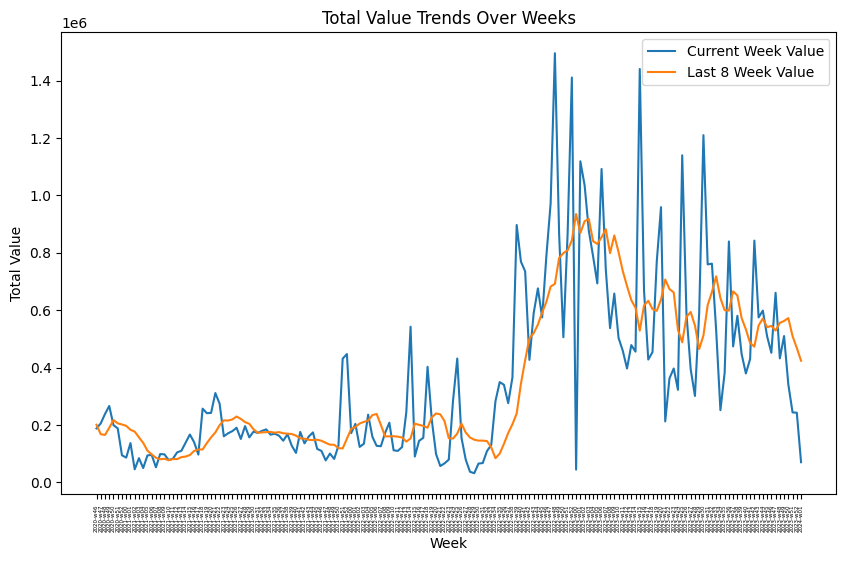

In [166]:
total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'Total_Value']
# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# Plot 'WeekCount' versus 'Last 8 Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('Total Value')
plt.title('Total Value Trends Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()

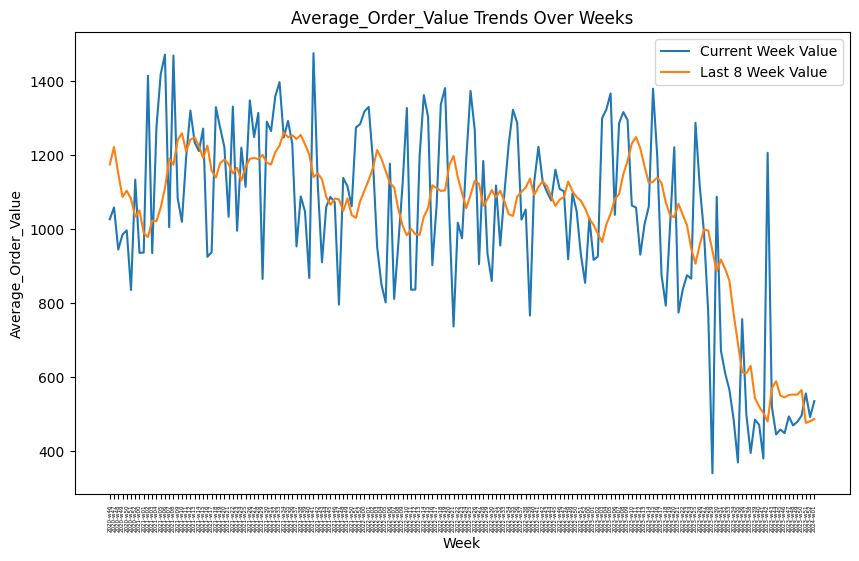

In [167]:
total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'Average_Order_Value']
# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# Plot 'WeekCount' versus 'Last 8 Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('Average_Order_Value')
plt.title('Average_Order_Value Trends Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()

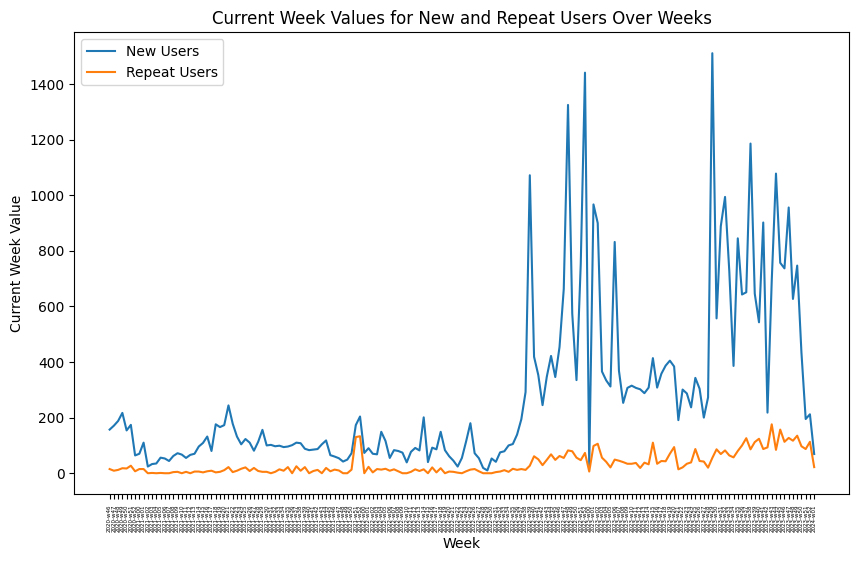

In [168]:
import matplotlib.pyplot as plt

# Filter for 'No_of_New_Users(First_Time_Users)'
new_users_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_New_Users(First_Time_Users)']

# Filter for 'No_of_Repeat_Users'
repeat_users_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_Repeat_Users']

# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value' for New Users
plt.plot(new_users_rows['WeekCount'], new_users_rows['Current Week Value'], label='New Users')

# Plot 'WeekCount' versus 'Current Week Value' for Repeat Users
plt.plot(repeat_users_rows['WeekCount'], repeat_users_rows['Current Week Value'], label='Repeat Users')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('Current Week Value')
plt.title('Current Week Values for New and Repeat Users Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()


In [49]:
# total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_Repeat_Users']
# # Plot the graph
# plt.figure(figsize=(10, 6))

# # Plot 'WeekCount' versus 'Current Week Value'
# plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# # Plot 'WeekCount' versus 'Last 8 Week Value'
# plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# # Set labels and title
# plt.xlabel('Week')
# plt.ylabel('No_of_Repeat_Users')
# plt.title('No_of_Repeat_Users Trends Over Weeks')
# plt.xticks(rotation=90, fontsize=4)
# plt.legend()

# # Show the plot
# plt.show()

In [50]:
new_df_1

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,User_Cohort_Labels,Product_Cohort_Labels
0,2020-w46,New Users<>Hero Products (Rs),11560.0,8830.500,Secondary_Explanatory,New Users,Hero Products
1,2020-w46,New Users<>High Value & Slow Moving Products (Rs),0.0,525.000,Secondary_Explanatory,New Users,High Value & Slow Moving Products
2,2020-w46,New Users<>Low Value & Slow Moving Products (Rs),2809.0,7587.625,Secondary_Explanatory,New Users,Low Value & Slow Moving Products
3,2020-w46,New Users<>New Business Products (Rs),139621.0,116825.000,Secondary_Explanatory,New Users,New Business Products
4,2020-w46,Recent & Loyal Users<>Hero Products (Rs),0.0,424.750,Secondary_Explanatory,Recent & Loyal Users,Hero Products
...,...,...,...,...,...,...,...
5000,2024-w01,Champion Users<>High Repeat Products (Rs),0.0,2410.000,Secondary_Explanatory,Champion Users,High Repeat Products
5001,2024-w01,Champion Users<>Hero Products (Rs),22534.0,70025.250,Secondary_Explanatory,Champion Users,Hero Products
5006,2024-w01,Repeat Churned Users<>Low Value & Slow Moving ...,0.0,0.000,Secondary_Explanatory,Repeat Churned Users,Low Value & Slow Moving Products
5008,2024-w01,Churned Users<>Low Value & Slow Moving Product...,0.0,0.000,Secondary_Explanatory,Churned Users,Low Value & Slow Moving Products


In [51]:
# # Group the data by Product Cohort Labels
# grouped_data = new_df_1.groupby('Product_Cohort_Lables')

# # Plot the data for each Product Cohort Label
# plt.figure(figsize=(12, 8))

# for label, group in grouped_data:
#     plt.plot(group['WeekCount'], group['Current Week Value'], label=label)

# plt.xlabel('Week Count')
# plt.ylabel('Current Week Value')
# plt.title('Current Week Value for Each Product Cohort Label')
# plt.legend(title='Product Cohort Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

In [52]:
df_agg = new_df_1.groupby(['WeekCount', 'Product_Cohort_Lables'])['Current Week Value'].sum().reset_index()
pivot_df = df_agg.pivot(index='WeekCount', columns='Product_Cohort_Lables', values='Current Week Value')
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Current Week Value vs Week Count for Product Cohort Lables')
plt.xlabel('Week Count')
plt.ylabel('Current Week Value')
ax.tick_params(axis='x', labelsize=4)
plt.show()

KeyError: 'Product_Cohort_Lables'

In [ ]:
df_agg_user = new_df_1.groupby(['WeekCount', 'User_Cohort_Lables'])['Current Week Value'].sum().reset_index()
pivot_df_user = df_agg_user.pivot(index='WeekCount', columns='User_Cohort_Lables', values='Current Week Value')
ax_user = pivot_df_user.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Current Week Value vs Week Count for User Cohort Lables')
plt.xlabel('Week Count')
plt.ylabel('Current Week Value')
ax_user.tick_params(axis='x', labelsize=4)
plt.show()

In [ ]:
# merged_dataframe['Variables'] = merged_dataframe.apply(lambda row: row['Variables'].replace('-', '<>') + f'({target_vars[0]})', axis=1)

In [ ]:
merged_dataframe

In [ ]:
averages_dict["2023-w52"].loc["Champions-Hero"]

In [ ]:
grouped_dict["2023-w44"].loc["Champions-Hero"]